In [28]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

"""
ネットワーク・アーキテクチャー
判別器と生成器のアーキテクチャは以下の通りです。
"""

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [29]:
"""
生成敵対ネットワークの作成に必要なライブラリのインポート
コードは主にPyTorchライブラリを使って開発されています
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt


# GPU利用可否確認
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# ハイパーパラメタ設定
epochs = 30
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


"""
画像変換とデータローダの作成
ここでは分類ではなく生成のトレーニングを行っているので
train_loaderのみがロードされます。
"""
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


"""
ネットワークの学習手順
識別器と生成器の損失はステップごとに更新される
判別器は本物と偽物を分類することを目的とする
ジェネレータは可能な限りリアルな画像を生成することを目的とする
"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # 識別器の学習
        # 本物の入力は，MNISTデータセットの実際の画像
        # 偽の入力はジェネレータから
        # 本物の入力は1に、偽物は0に分類されるべきである
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()


        # Generatorのトレーニング
        # ジェネレータにとっての目標は 識別者に全てが1であると信じさせること
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

100.0%


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100.0%


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw




100.0%
100.0%


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Epoch 0 Iteration 100: discriminator_loss 0.626 generator_loss 0.928
Epoch 0 Iteration 200: discriminator_loss 0.687 generator_loss 0.711
Epoch 0 Iteration 300: discriminator_loss 0.672 generator_loss 0.782
Epoch 0 Iteration 400: discriminator_loss 0.616 generator_loss 0.814
Epoch 0 Iteration 500: discriminator_loss 0.575 generator_loss 0.821
Epoch 0 Iteration 600: discriminator_loss 0.545 generator_loss 0.860
Epoch 0 Iteration 700: discriminator_loss 0.340 generator_loss 1.099
Epoch 0 Iteration 800: discriminator_loss 0.539 generator_loss 0.859
Epoch 0 Iteration 900: discriminator_loss 0.545 generator_loss 0.795
Epoch 0 Iteration 938: discriminator_loss 0.517 generator_loss 0.907
Epoch 1 Iteration 100: discriminator_loss 0.412 generator_loss 1.225
Epoch 1 Iteration 200: discriminator_loss 0.440 generator_loss 1.254
Epoch 1 Iteration 300: dis

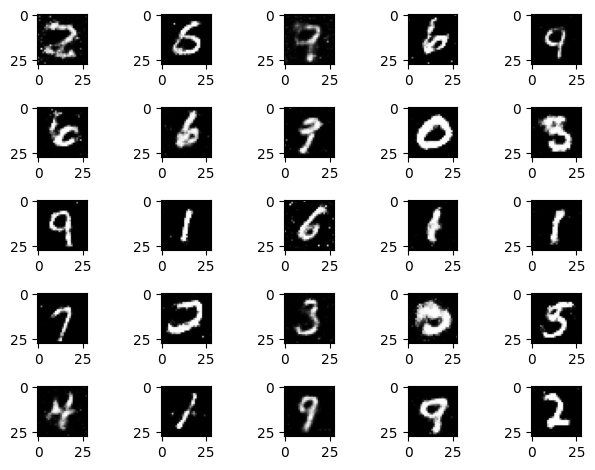

In [34]:
fig = plt.figure()
for i in range(25):
  noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
  noise = noise.to(device)
  fake_inputs = G(noise)
  ax = fig.add_subplot(5, 5, i+1)
  ax.imshow(fake_inputs[0][0].cpu().detach().numpy().reshape(28,28), cmap="gray")
plt.tight_layout()